## Package imports

In [25]:

# Backbone imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# Single Cell imports
import anndata
import scanpy as sc
import scrublet as scr
import harmonypy
from pybiomart import Server

import warnings
warnings.filterwarnings(action="ignore")


## Package Settings

In [26]:

sc.settings.verbosity = 3
#sc.settings.writedir()
sc.logging.print_header()
%matplotlib inline


scanpy==1.8.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7


In [27]:

# Directories and required files

data_dir = Path("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/molecule_files")

#load dataset
# adata_bc_raw is B-Cells from all samples merged with no cleaning at all
adata_bc_raw = sc.read("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/molecule_files/adata_bc.h5ad", cache = True)



In [28]:

#look at dataframe

adata_bc_raw


AnnData object with n_obs × n_vars = 5122 × 68886
    obs: 'processed_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_sex_linked', 'log1p_total_counts_sex_linked', 'pct_counts_sex_linked', 'total_counts_is_human', 'log1p_total_counts_is_human', 'pct_counts_is_human', 'scrublet_putative_doublet', 'scrublet_score', 'n_genes', 'dataset', 'cell_type'
    layers: 'log_raw', 'log_soupX', 'raw', 'soupX'

## Initial Data Cleanup

In [29]:
# Don't remove any genes here
# But remove cells based on whatever you want
qc_params = {
    "min_genes_per_cell": 800,
    "max_pct_counts_mitochondrial": 20,
    "max_counts_hemoglobin": 50, 
}

In [30]:


qc_bc = adata_bc_raw.copy()
sc.pp.filter_cells(qc_bc, min_genes=qc_params.get("min_genes_per_cell", 800))
idx = qc_bc.obs.pct_counts_mitochondrial < qc_params.get("max_pct_counts_mitochondrial", 30)
idx &= qc_bc.obs.total_counts_hemoglobin < qc_params.get("max_counts_hemoglobin", 100)
qc_bc = qc_bc[idx, :].copy()


In [31]:
qc_bc

AnnData object with n_obs × n_vars = 5122 × 68886
    obs: 'processed_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_sex_linked', 'log1p_total_counts_sex_linked', 'pct_counts_sex_linked', 'total_counts_is_human', 'log1p_total_counts_is_human', 'pct_counts_is_human', 'scrublet_putative_doublet', 'scrublet_score', 'n_genes', 'dataset', 'cell_type'
    layers: 'log_raw', 'log_soupX', 'raw', 'soupX'

In [32]:
# greedy regex to define grouping variable
# primary_tumor_1 -> primary_tumor
# primary_tumor_2 -> primary_tumor
# pdx_1 -> pdx
qc_bc.obs["data_type"] = qc_bc.obs.dataset.str.extract("(.*)_")

# Merging may or may not remove variable annotations
qc_bc.var["species"] = "hsapiens"
qc_bc.var.loc[qc_bc.var_names.isin(qc_bc.var_names[qc_bc.var.species.isin(["mmusculus"])])] = "mmusculus"

annotate_var(qc_bc, "hsapiens")
annotate_var(qc_bc, "mmusculus")


##  gene filtering

In [33]:
sc.pp.filter_genes(qc_bc, min_cells=5)
sc.pp.normalize_total(qc_bc, exclude_highly_expressed=True, target_sum=None)
qc_bc.layers["normed"] = qc_bc.X.copy()
sc.pp.log1p(qc_bc)

sc.pp.highly_variable_genes(qc_bc, flavor="cell_ranger", n_top_genes=5000) # should be changed for subclusters
qc_bc.var.loc[qc_bc.var.exclude_from_highly_variable, "highly_variable"] = False

sc.pp.pca(qc_bc, use_highly_variable=True)

for col, dtype in zip(qc_bc.var.columns, qc_bc.var.dtypes):
    if isinstance(dtype, pd.CategoricalDtype):
        if False in qc_bc.var[col]:
            qc_bc.var[col] = qc_bc.var[col].astype(bool)
    else:
        qc_bc.var[col] = qc_bc.var[col].astype(str)

filtered out 41873 genes that are detected in less than 5 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['IGKC', 'JCHAIN', 'MALAT1', 'IGHG4', 'IGHG2', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'CCL4', 'CCL4L2', 'IGLC2', 'IGLC3', 'MT-CO1', 'Gm42418']
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


# Batch correction with Harmony
#### Here we need to determine a few covariates across which to integrate the data. 

In [34]:

# chemistry corrections

hy_bc = qc_bc.copy()
hy_bc.obs["chemistry"] = "v3"
hy_bc.obs.loc[hy_bc.obs.data_type.isin(["primary_tumor"]), "chemistry"] = "v2"

outs = harmonypy.run_harmony(
    hy_bc.obsm["X_pca"], 
    meta_data=hy_bc.obs, 
    vars_use=["chemistry", "data_type"], 
    theta=[2, 2]
)


2022-07-09 11:49:27,486 - harmonypy - INFO - Iteration 1 of 10
2022-07-09 11:49:29,554 - harmonypy - INFO - Iteration 2 of 10
2022-07-09 11:49:31,525 - harmonypy - INFO - Converged after 2 iterations


In [35]:
#compute PCAs

hy_bc.obsm["X_pca_harmony"] = outs.Z_corr.T
sc.pp.neighbors(hy_bc, use_rep="X_pca_harmony", n_neighbors=20, metric="correlation")


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


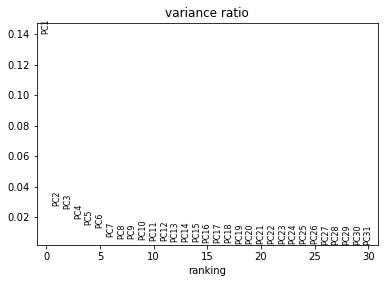

In [36]:

#variance plot for PCSs 

sc.pl.pca_variance_ratio(hy_bc)


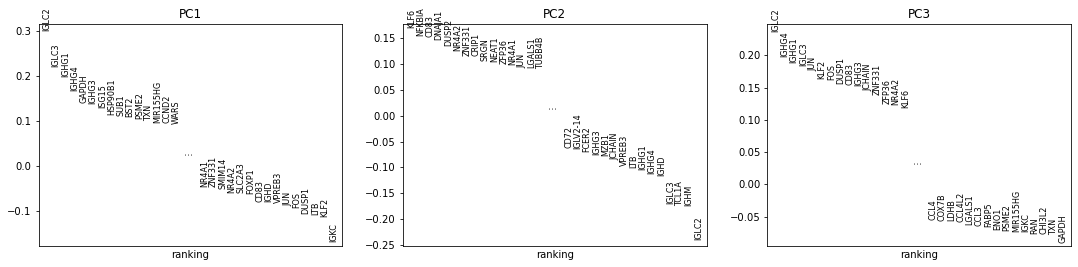

In [37]:
#check PCSs

sc.pl.pca_loadings(hy_bc)


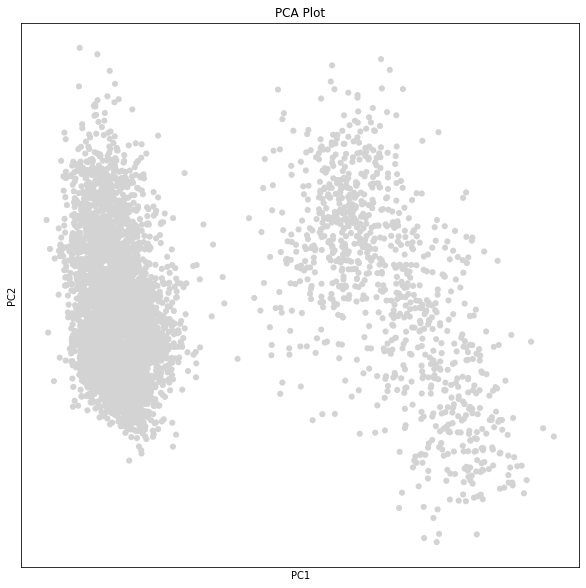

In [38]:

# look at PCA plot

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.pca(hy_bc,ax=ax, legend_loc="right margin", legend_fontsize = "x-large", size=150, title ="PCA Plot")


In [39]:

#compute UMAP

sc.tl.umap(hy_bc)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


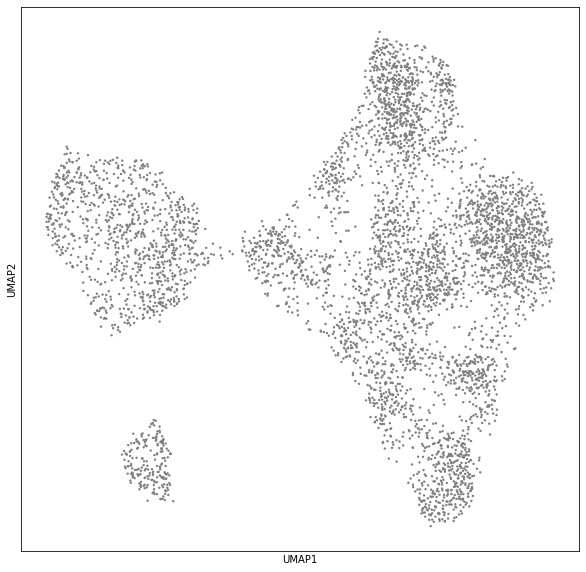

In [40]:

# check UMAP

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.scatter(hy_bc, ax=ax, basis="umap") 


In [ ]:
# compute leinen

sc.tl.leiden(hy_bc)


running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [52]:

# rank genes

sc.tl.rank_genes_groups(hy_bc, "leiden", method="wilcoxon", use_raw=False)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


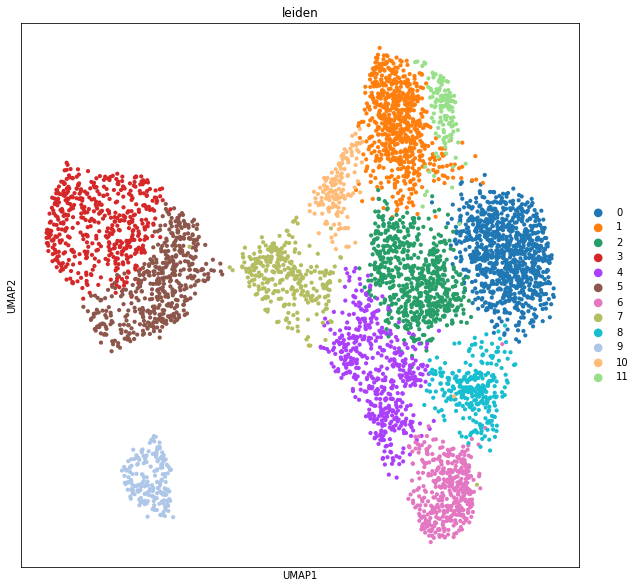

In [53]:

# check leiden on new cluster- 

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.scatter(hy_bc, ax=ax, basis="umap", size=70, color="leiden")
#looks a little better, but the same plot


normalizing counts per cell
    finished (0:00:00)


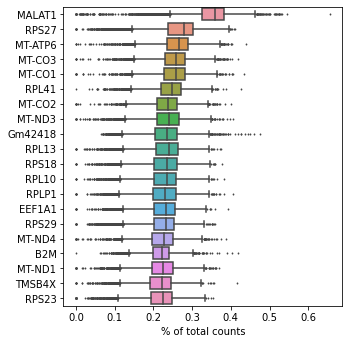

In [54]:

sc.pl.highest_expr_genes(hy_bc, n_top=20, )


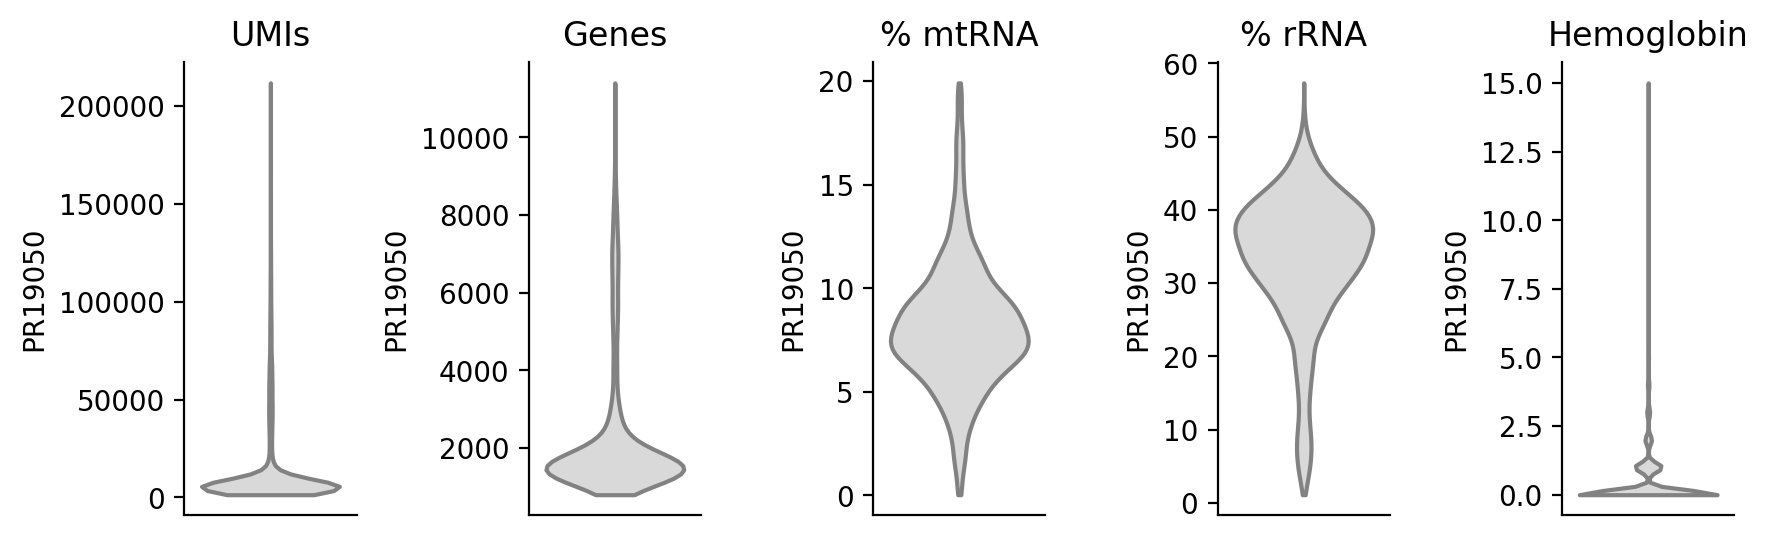

In [55]:

qc_metrics_violin(hy_bc).savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/subcluster_figures")


In [56]:

# write df to save time in the future

output_path = data_dir / "hy_bc.h5ad"

hy_bc.write(output_path)
